## Generalization to Bayesian Softmax Regression

In [2]:
%pip install pymc pytensor

In [3]:
import pymc as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.special import expit as logistic
import matplotlib.pyplot as plt
import arviz as az
import requests
import io



In [4]:
az.style.use('arviz-darkgrid')

In [5]:
target_url = 'https://raw.githubusercontent.com/cfteach/brds/main/datasets/iris.csv'

download = requests.get(target_url).content
iris = pd.read_csv(io.StringIO(download.decode('utf-8')))

iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


<ipython-input-6-7a5e472054ba>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(iris, x='petal_width', y='species', inner='stick', palette='Dark2')


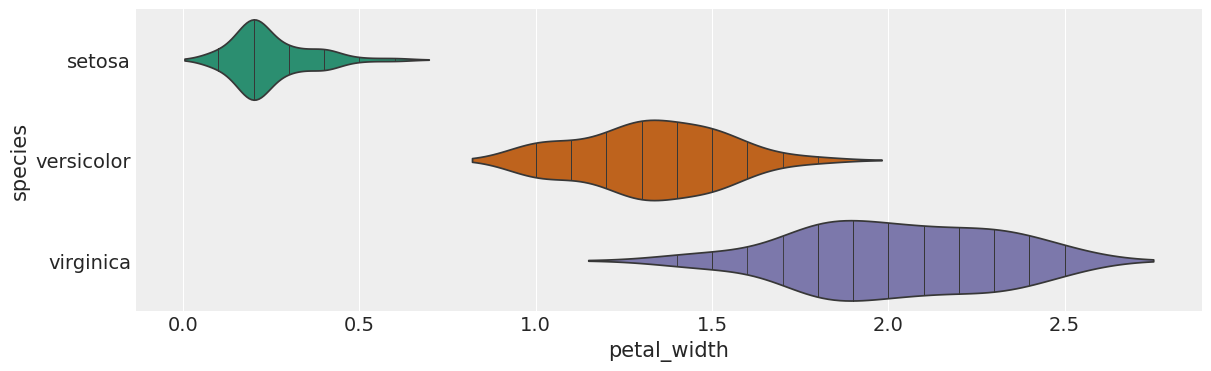

In [6]:
# @title species vs petal_width

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(iris['species'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(iris, x='petal_width', y='species', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

### Recipe 1: Dealing with correlated data

<ipython-input-7-c7a84d82f61e>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = iris[iris['species'] != 'virginica'].corr()


[Text(0, 0.5, 'sepal_length'),
 Text(0, 1.5, 'sepal_width'),
 Text(0, 2.5, 'petal_length'),
 Text(0, 3.5, 'petal_width')]

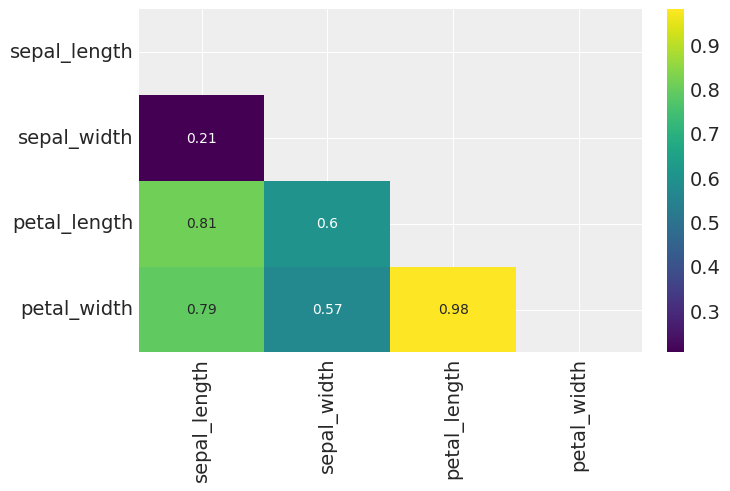

In [7]:
corr = iris[iris['species'] != 'virginica'].corr()
mask = np.tri(*corr.shape).T
g = sns.heatmap(corr.abs(), mask=mask, annot=True, cmap='viridis')
g.set_xticklabels(g.get_yticklabels(), rotation = 90, fontsize = 14)
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 14)

**Notes**


(i) Correlated data has typically less power to restrict the model; correlated variables translate into wider combinations of coefficients that are able to explain the data.

(ii) One solution when dealing with highly correlated variables is to remove one (or more than one) correlated variable.

(iii) Another option is scaling all non-binary variables to have a mean of 0, and then using (see logistic regression model parameters):

$\beta \sim StudentT(0,\nu,sd)$
$sd$ should be chosen to weekly inform us about the expected value for the scale. The normality parameter $\nu$ is typically chosen to be in the range (3,7). This prior is saying that in general we expect the coefficienct to be small, but we use wide tails because occasionally we will find some larger coefficients.

### Recipe 2: Dealing with correlated data

In [8]:
df = iris.query("species == ('setosa', 'versicolor')")
df = df[45:]   # let's select two unbalanced classes
y_unb = pd.Categorical(df['species']).codes
x_n = ['sepal_length', 'sepal_width']
x_unb = df[x_n].values

print(y_unb) #this is why is unbalanced

[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


Doing the usual thing: build the logistic regression…



In [9]:
with pm.Model() as model_unb:
    α = pm.Normal('α', mu=0, sigma=10)
    β = pm.Normal('β', mu=0, sigma=2, shape=len(x_n))

    μ = α + pm.math.dot(x_unb, β)
    θ = 1 / (1 + pm.math.exp(-μ))
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * x_unb[:,0])

    yl = pm.Bernoulli('yl', p=θ, observed=y_unb)

    trace_unb = pm.sample(1000, target_accept=0.95)

Text(0, 0.5, 'sepal_width')

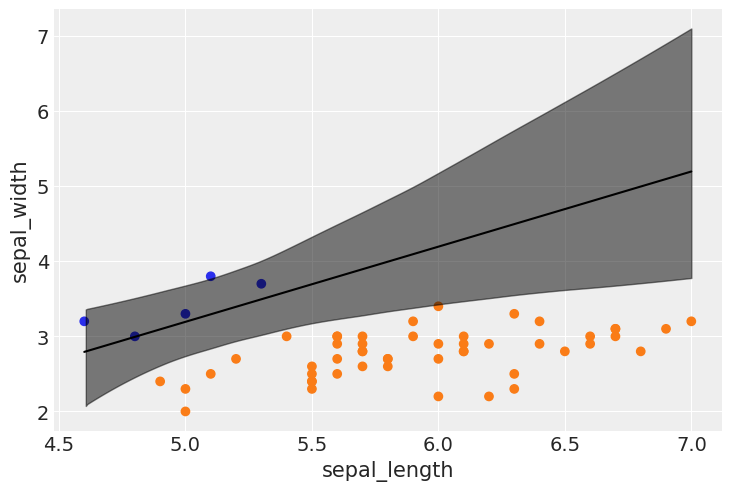

In [10]:
idx = np.argsort(x_unb[:,0])

bd = trace_unb.posterior['bd'].mean(axis=0).mean(axis=0)[idx]

plt.scatter(x_unb[:,0], x_unb[:,1], c= [f'C{x}' for x in y_unb])
plt.plot(x_unb[:,0][idx], bd, color='k')

az.plot_hdi(x_unb[:,0], trace_unb.posterior['bd'], color='k')

plt.xlabel(x_n[0])
plt.ylabel(x_n[1])

**Notes**

(i) In case of an unbalanced dataset, logistic regression can run into some trouble: the boundary cannot be determined as accurately as when the dataset is more balanced.

(ii) The decision boundary is "shifted" towards the less abundant class, and the uncertainty band is larger.

(iii) It is always good to have a balanced dataset. If you do have unbalanced data though, you should be careful when you interpret results: check the uncertainty of the model, and run some posterior predictive checks for consistency. Another option is to input more prior information if available and/or run an alternative model.

### Generalization to multiple classes: Softmax Regression

**Notes**

In order to generalize to mutliple classes, two modifications are needed:

(i) We use a softmax (see also Boltzmann distribution in physics), which is defined as:


$softmax_{i}(\mu)= \frac{exp(\mu_{i})}{\sum_{k}exp(\mu_{k})}$


(ii) We then replace the Bernoulli distribution with the categorical distribution. As the Bernoulli (single coin flip) is a special case of a Binomial (n coin flips), the categorical (single roll of a die) is a special case of the multinomial distribution (n rolls of a die).

In [11]:
iris.columns[:-1]

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], dtype='object')

In [12]:
iris = sns.load_dataset('iris')
y_s = pd.Categorical(iris['species']).codes
x_n = iris.columns[:-1]
x_s = iris[x_n].values

x_s = (x_s - x_s.mean(axis=0)) / x_s.std(axis=0)

print(np.shape(x_s))
print(np.shape(y_s))
#print(x_n)
#print(iris)

(150, 4)
(150,)


In [13]:
with pm.Model() as model_s:
    α = pm.Normal('α', mu=0, sigma=5, shape=3)
    β = pm.Normal('β', mu=0, sigma=5, shape=(4,3))
    μ = pm.Deterministic('μ', α + pm.math.dot(x_s, β))
    θ = pm.math.softmax(μ, axis = 1)
    yl = pm.Categorical('yl', p=θ, observed=y_s)
    idata_s = pm.sample(2000, target_accept=.95)


Note that you need to call .eval() on Theano tensors to convert them to NumPy arrays before passing them to the softmax function.

In [14]:
data_pred = idata_s.posterior['μ'].mean(axis=0).mean(axis=0).values
print(np.shape(data_pred))
print(np.shape(y_s))

(150, 3)
(150,)


In [15]:
y_pred = [np.exp(point)/np.sum(np.exp(point), axis=0)
          for point in data_pred]

res_t = np.sum(y_s == np.argmax(y_pred, axis=1)) / len(y_s)
print("accuracy is: {:1.3f}".format(res_t))


accuracy is: 0.980


In [16]:
az.summary(idata_s).head(15)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α[0],-1.128,3.766,-7.880,6.266,0.066,0.054,3236.0,2625.0,1.0
α[1],5.855,3.194,0.224,12.107,0.060,0.043,2830.0,2885.0,1.0
α[2],-4.826,3.432,-11.594,1.316,0.061,0.045,3133.0,2971.0,1.0
"β[0, 0]",-2.461,4.161,-10.526,5.205,0.067,0.059,3794.0,3053.0,1.0
"β[0, 1]",1.970,3.316,-4.186,8.424,0.068,0.050,2369.0,2622.0,1.0
"β[0, 2]",0.606,3.332,-5.372,7.274,0.069,0.052,2312.0,2244.0,1.0
"β[1, 0]",3.258,3.395,-2.710,9.906,0.066,0.048,2678.0,2749.0,1.0
"β[1, 1]",-0.864,3.025,-6.356,5.093,0.064,0.046,2235.0,2242.0,1.0
"β[1, 2]",-2.268,3.050,-8.011,3.336,0.065,0.046,2227.0,2475.0,1.0
"β[2, 0]",-6.319,4.300,-14.562,1.564,0.071,0.054,3708.0,2755.0,1.0


**Notes**

(i) 98% is the accuracy on our data; **a true test to evaluate the performance of our model will be to check it on data not used to fit the model**

(ii) You can check that we obtained a wide posterior. This is a result of the fact softmax normalizes probability to 1. Therefore, when we used priors on the parameters of 4 species, in reality we can "eliminate" one species" from the problem, in that one of them can be calculated from the other 3 once we know their probabilities (again, they have to sum up to 1!)

(iii) Below is a suggested solution, that does fix the extra parameters to some value, e.g., zero

In [17]:
with pm.Model() as model_sf:
    α = pm.Normal('α', mu=0, sigma=2, shape=2)
    β = pm.Normal('β', mu=0, sigma=2, shape=(4,2))
    α_f = pm.math.concatenate([[0] ,α])
    β_f = pm.math.concatenate([np.zeros((4,1)) , β], axis=1)
    μ = pm.Deterministic('μ', α_f + pm.math.dot(x_s, β_f))
    θ = pm.math.softmax(μ, axis = 1)
    yl = pm.Categorical('yl', p=θ, observed=y_s)
    idata_sf = pm.sample(2000, target_accept=.92)


In [18]:
data_pred_sf = idata_sf.posterior['μ'].mean(axis=0).mean(axis=0).values

y_pred_sf = [np.exp(point)/np.sum(np.exp(point), axis=0)
          for point in data_pred_sf]

res_sf = np.sum(y_s == np.argmax(y_pred_sf, axis=1)) / len(y_s)
print("accuracy is: {:1.3f}".format(res_sf))

accuracy is: 0.973


In [19]:
mu_pred = idata_sf.posterior['μ'].mean(axis=0)
print(np.shape(mu_pred), type(mu_pred))

(2000, 150, 3) <class 'xarray.core.dataarray.DataArray'>


In [20]:
import xarray as xr

In [21]:
def softmax(x):
    e_x = np.exp(x)
    return e_x.values / np.sum(e_x, axis = 2, keepdims=True).values


In [22]:
res_sm= softmax(mu_pred)
print(np.shape(res_sm))

(2000, 150, 3)


In [23]:
# Average probabilities for prediction
mean_probabilities = np.mean(res_sm, axis=0)

# Uncertainty estimation
lower_bound = np.percentile(res_sm, 2.5, axis=0)
upper_bound = np.percentile(res_sm, 97.5, axis=0)

# class_assignment
class_prediction = np.argmax(y_pred_sf, axis=1)

In [24]:
print(np.shape(class_prediction),np.shape(mean_probabilities),np.shape(lower_bound))

(150,) (150, 3) (150, 3)


In [25]:
print("\n" + "=" * 39)
print("DATA:")
print("=" * 39)

print("class, probabilities, ranges(94%HDI):")
for count, (g, h, i, j, k) in enumerate(zip(y_s, class_prediction, mean_probabilities, lower_bound, upper_bound)):
    print(f"data point: {count}, ground-truth: {g}, class: {h}")
    for l in range(3):
        print(f"    idx: {l}, mean prob. {i[l]:.4f}, 94% HDI: [{j[l]:.4f},{k[l]:.4f}]")
    if count >= 5:
      break
print("=" * 39)



DATA:
class, probabilities, ranges(94%HDI):
data point: 0, ground-truth: 0, class: 0
    idx: 0, mean prob. 0.9905, 94% HDI: [0.9698,0.9991]
    idx: 1, mean prob. 0.0095, 94% HDI: [0.0009,0.0302]
    idx: 2, mean prob. 0.0000, 94% HDI: [0.0000,0.0000]
data point: 1, ground-truth: 0, class: 0
    idx: 0, mean prob. 0.9579, 94% HDI: [0.8851,0.9927]
    idx: 1, mean prob. 0.0421, 94% HDI: [0.0073,0.1149]
    idx: 2, mean prob. 0.0000, 94% HDI: [0.0000,0.0000]
data point: 2, ground-truth: 0, class: 0
    idx: 0, mean prob. 0.9893, 94% HDI: [0.9682,0.9987]
    idx: 1, mean prob. 0.0107, 94% HDI: [0.0013,0.0318]
    idx: 2, mean prob. 0.0000, 94% HDI: [0.0000,0.0000]
data point: 3, ground-truth: 0, class: 0
    idx: 0, mean prob. 0.9845, 94% HDI: [0.9522,0.9981]
    idx: 1, mean prob. 0.0155, 94% HDI: [0.0019,0.0478]
    idx: 2, mean prob. 0.0000, 94% HDI: [0.0000,0.0000]
data point: 4, ground-truth: 0, class: 0
    idx: 0, mean prob. 0.9948, 94% HDI: [0.9820,0.9996]
    idx: 1, mean prob.

### Final remarks: Robust Logistic Regression (extra, for the curious…)

Let’s take the dataset for the species setosa and versicolor only. Let’s complicate the problem by assuming the presence of unusual seros and/or ones in our dataset.

Text(0.5, 0, 'sepal_length')

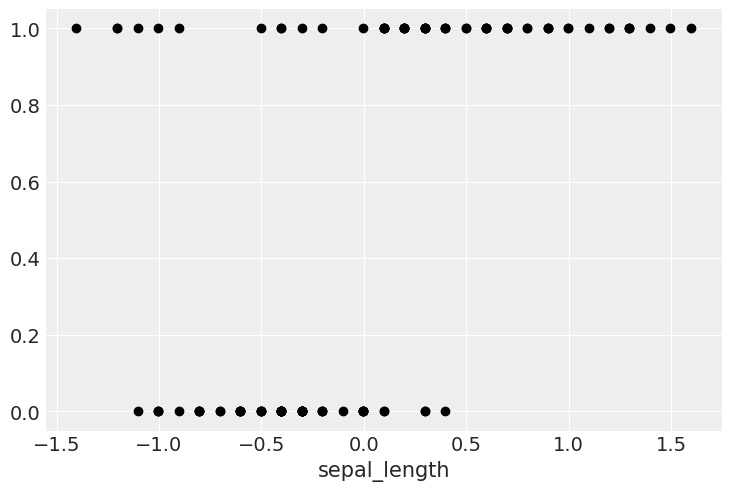

In [33]:
iris = sns.load_dataset("iris")
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length'
x_0 = df[x_n].values
y_0 = np.concatenate((y_0, np.ones(6, dtype=int)))
x_0 = np.concatenate((x_0, [4.2, 4.5, 4.0, 4.3, 4.2, 4.4]))
x_c = x_0 - x_0.mean()
plt.plot(x_c, y_0, 'o', color='k');
plt.xlabel(x_n)

We have some versicolor (category 1) with some unusually short sepal_length...

We can fix this with a **mixture model**. We say that the outpu variable comes with $\pi$ probability of random guessing (0.5 chance for category 1 to be indeed 1), and with 1-$\pi$ probability from a logistic regression model:

$p= \pi \ 0.5 + (1-\pi) \ logistic(\alpha+X\beta)$

Notice that when $\pi=1$, we get $p=0.5$ (random guess), whereas when $\pi=0$ we get the logistic regression.

This model can be implemented with a slight modification of what we saw before.

N.B. $\pi$ is a new variable in our model

In [35]:
with pm.Model() as model_rlg:
    α = pm.Normal('α', mu=0, sigma=10)
    β = pm.Normal('β', mu=0, sigma=10)

    μ = α + x_c *  β
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)

    π = pm.Beta('π', 1., 1.)
    p = π * 0.5 + (1 - π) * θ

    yl = pm.Bernoulli('yl', p=p, observed=y_0)

    idata_rlg = pm.sample(2000, target_accept=0.95,  tune = 2000, return_inferencedata=True)

([<matplotlib.axis.XTick at 0x7d1db3434c10>,
 [Text(-2.0, 0, '3.4'),
  Text(-1.5, 0, '3.9'),
  Text(-1.0, 0, '4.4'),
  Text(-0.5, 0, '4.9'),
  Text(0.0, 0, '5.4'),
  Text(0.5, 0, '5.9'),
  Text(1.0, 0, '6.4'),
  Text(1.5, 0, '6.9'),
  Text(2.0, 0, '7.4')])

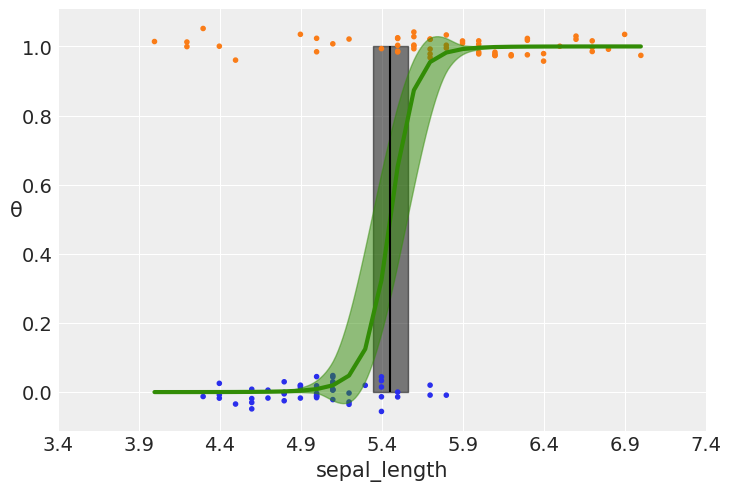

In [36]:
theta = idata_rlg.posterior['θ'].mean(axis=0).mean(axis=0)
idx = np.argsort(x_c)

np.random.seed(123)


plt.plot(x_c[idx], theta[idx], color='C2', lw=3)

plt.vlines(idata_rlg.posterior['bd'].mean(), 0, 1, color='k')

bd_hpd = az.hdi(idata_rlg.posterior['bd'])


plt.fill_betweenx([0, 1], bd_hpd.bd[0].values, bd_hpd.bd[1].values, color='k', alpha=0.5)


plt.scatter(x_c, np.random.normal(y_0, 0.02),
            marker='.', color=[f'C{x}' for x in y_0])


az.plot_hdi(x_c, idata_rlg.posterior['θ'], color='C2')  #green band


plt.xlabel(x_n)
plt.ylabel('θ', rotation=0)
# use original scale for xticks
locs, _ = plt.xticks()
plt.xticks(locs, np.round(locs + x_0.mean(), 1))